# Doppler Correspondence Tutorial 🚀 

---

## Contents
1. **Closest-Point Correspondence**  
   Recall the classic 3-D Euclidean nearest-neighbour

2. **Doppler Correspondence**    
   Direct matching without iterative refinement for local registraiton

3. **ICP vs Doppler Correspondence**  
   Compare the rigid transformations produced by Iterative Closest Point and by Doppler Correspondence.

4. **Doppler Correspondence + RANSAC**  
   Maximize consensus for outlier rejection
---


## 1 · Closest-Point Correspondence  

Given two unordered point sets  

$$
P=\left\{\,\mathbf p_i\in\mathbb R^{3}\mid i=1,\dots,N \right\},\qquad
Q=\left\{\,\mathbf q_j\in\mathbb R^{3}\mid j=1,\dots,M \right\},
$$

Assigns to every source point the **nearest neighbour**
in target point:

$$
c(i)=\operatorname*{arg\,min}_{1\le j\le M}\;
      \bigl\lVert\mathbf p_i-\mathbf q_j\bigr\rVert_2,
\qquad
(\mathbf p_i,\mathbf q_{c(i)})\in\mathcal C_{\text{closest}}.
$$


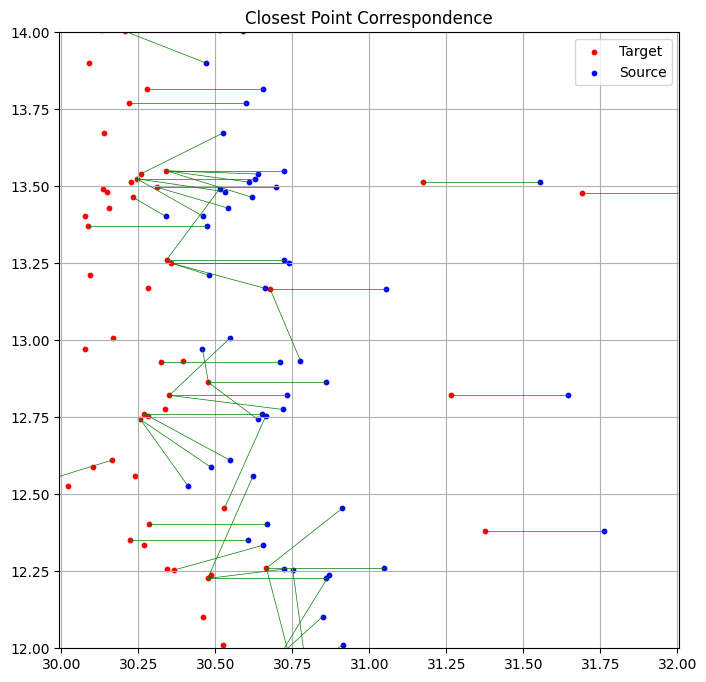

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.spatial.transform import Rotation as R

# Load example data from 4D Radar
src = np.load("./data_odom/frame_099.npy")   
tgt = np.load("./data_odom/frame_100.npy")   
src_dop = np.load("./data_odom/frame_099_dop.npy")
tgt_dop = np.load("./data_odom/frame_100_dop.npy")

# find closest point correspondence
tree = cKDTree(tgt)
dists, idx = tree.query(src, k=1)

# 2D visualization of the closest point correspondence
plt.figure(figsize=(8, 8))
plt.scatter(tgt[:, 0], tgt[:, 1], c='red', label='Target', s=10)
plt.scatter(src[:, 0], src[:, 1], c='blue', label='Source', s=10)
for i in range(len(src)):
    pt1_xy = src[i, :2]
    pt2_xy = tgt[idx[i], :2]
    plt.plot([pt1_xy[0], pt2_xy[0]], [pt1_xy[1], pt2_xy[1]], c='green', linewidth=0.5)

plt.legend()
plt.axis("equal")
plt.title("Closest Point Correspondence")
plt.grid('on')
plt.xlim([30, 32])
plt.ylim([12, 14])
plt.show()


## 2 · Doppler Correspondence  

### Doppler Feature  

For every points compute:

$$
f(P) \;=\; \lVert \mathbf p \rVert^{2}\; + \; \lVert \mathbf p \rVert
        \,v_{\text{p,dop}}\;\Delta t
$$  

$$
g(Q) \;=\; \lVert \mathbf q \rVert^{2}\; - \; \lVert \mathbf q \rVert
        \,v_{\text{q,dop}}\;\Delta t
$$  

* “+” → previous scan (source) | “−” → current scan (target)  
* Translation-invariant, small-rotation-invariant.

---

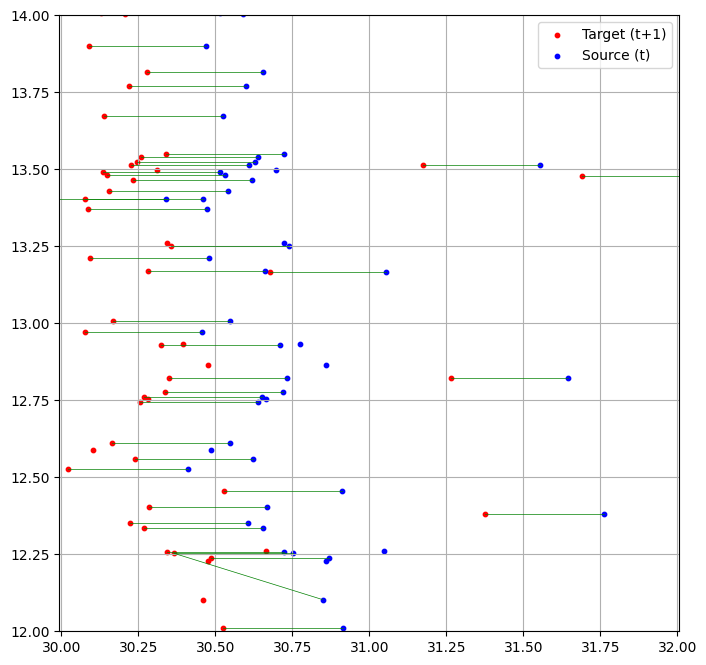

In [36]:
delta_t = 1/12 # 12 Hz

def left_doppler_feature(xyz, dop):
    r = np.linalg.norm(xyz, axis=1)
    return r**2 + r * dop * delta_t

def right_doppler_feature(xyz, dop):
    r = np.linalg.norm(xyz, axis=1)
    return r**2 - r * dop * delta_t

LeftDopplerFeat  = left_doppler_feature(src, src_dop)
RightDopplerFeat = right_doppler_feature(tgt, tgt_dop)

tree = cKDTree(RightDopplerFeat[:, None])
dists, idx = tree.query(LeftDopplerFeat[:, None], k=1)

src_matched = src                         
tgt_matched = tgt[idx]                   
spatial_dist = np.linalg.norm(src_matched - tgt_matched, axis=1)  # (N,)

mask = spatial_dist <= 1.0   # Region of interest

plt.figure(figsize=(8, 8))
plt.scatter(tgt[:, 0], tgt[:, 1], c='red', label='Target (t+1)', s=10)
plt.scatter(src[:, 0], src[:, 1], c='blue', label='Source (t)', s=10)

for i in np.where(mask)[0]:
    pt1 = src[i, :2]
    pt2 = tgt[idx[i], :2]
    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], c='green', linewidth=0.5)


plt.axis("equal")
plt.legend()
plt.grid('on')
plt.xlim([30, 32])
plt.ylim([12, 14])
plt.show()


### Even without iterative refinement, the very first matching already yields highly consistent correspondences.

### ICP vs Doppler Correspondence  

|                | ICP (closest-point) | **Doppler Correspondence** |
|----------------|---------------------|-------------|
| Search         | 3-D KD-tree + **iterations** | 1-D KD-tree + **Non-Iterative** |



In [37]:
# Utility functions
from scipy.spatial.transform import Rotation as R

def best_fit_transform(src_pts, tgt_pts):
    """
    Compute the best rigid transform that aligns src_pts to tgt_pts.
    """
    assert src_pts.shape == tgt_pts.shape
    centroid_src = np.mean(src_pts, axis=0)
    centroid_tgt = np.mean(tgt_pts, axis=0)

    src_centered = src_pts - centroid_src
    tgt_centered = tgt_pts - centroid_tgt

    H = src_centered.T @ tgt_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    t = centroid_tgt - R @ centroid_src
    return R, t

# ICP
def icp_closest_point(src_init, tgt, max_iter=20, tol=1e-5,
                      max_correspondence_distance=2.0, verbose=True):
    """
    ICP with closest point matching and correspondence rejection by distance.
    """
    src = src_init.copy()
    prev_error = np.inf
    errors = []
    R_total, t_total = np.eye(3), np.zeros(3)

    for i in range(max_iter):
        tree = cKDTree(tgt)
        dists, idx = tree.query(src, k=1)
        tgt_corr = tgt[idx]

        mask = dists <= max_correspondence_distance
        src_valid = src[mask]
        tgt_valid = tgt_corr[mask]

        R, t = best_fit_transform(src_valid, tgt_valid)
        src = (R @ src.T).T + t

        R_total = R @ R_total
        t_total = R @ t_total + t

        mean_error = np.mean(dists[mask])
        errors.append(mean_error)

        if abs(prev_error - mean_error) < tol:
            break
        prev_error = mean_error
    
    src_corr = src_init[mask]
    tgt_corr = tgt_corr[mask]
    
    return R_total, t_total, src_corr, tgt_corr

def visualize_correspondences(src_corr, tgt_corr):

    plt.figure(figsize=(8, 6))
    plt.scatter(src_corr[:, 0], src_corr[:, 1], c='blue', label='Source', s=10)
    plt.scatter(tgt_corr[:, 0], tgt_corr[:, 1], c='red', label='Target Correspondence', s=10)

    for p1, p2 in zip(src_corr, tgt_corr):
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='green')

    plt.title("ICP Closest-Point Correspondences")
    plt.axis("equal")
    plt.legend()
    plt.grid(True)
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.xlim([10, 32])
    plt.ylim([8, 14])
    plt.tight_layout()
    plt.show()

# GT Pose 1
t1 = np.array([43.977499, -4.361636, 3.083921])
q1 = np.array([-0.002133, -0.004575, -0.050881, 0.998692])
R1 = R.from_quat(q1).as_matrix()

# GT Pose 2
t2 = np.array([44.427248, -4.412951, 3.117977])
q2 = np.array([-0.001514, -0.004157, -0.050768, 0.998701])
R2 = R.from_quat(q2).as_matrix()

T1 = np.eye(4)
T1[:3, :3] = R1
T1[:3, 3] = t1

T2 = np.eye(4)
T2[:3, :3] = R2
T2[:3, 3] = t2

T_rel = np.linalg.inv(T2) @ T1

R_rel = T_rel[:3, :3]
t_rel = T_rel[:3, 3]

rotvec = R.from_matrix(R_rel).as_rotvec()
angle_deg = np.rad2deg(np.linalg.norm(rotvec))

print("Ground Truth Transformation:")
print("Relative Rotation Matrix:\n", R_rel)
print("Relative Translation Vector:\n", t_rel)
print("Rotation Angle (deg):", angle_deg)


Ground Truth Transformation:
Relative Rotation Matrix:
 [[ 9.99999572e-01  2.23275661e-04 -8.97363826e-04]
 [-2.22203228e-04  9.99999261e-01  1.19501571e-03]
 [ 8.97629981e-04 -1.19481580e-03  9.99998883e-01]]
Relative Translation Vector:
 [-0.45290601  0.00552683 -0.03021261]
Rotation Angle (deg): 0.08657047119017945


### Closest Point Correspondence from ICP

In [38]:
# --- Ground Truth ---
gt_trans = np.array([-0.45290601, 0.00552683, -0.03021261])

# --- ICP ---
R_icp, t_icp, src_corr, tgt_corr = icp_closest_point(src, tgt)   

# --- Compute Relative Translation Error ---
trans_error = np.linalg.norm(t_icp - gt_trans)

# --- Print Results ---
print("Ground Truth Translation:", gt_trans)
print(f"RPE Translation Error: {trans_error:.6f} meters")

Ground Truth Translation: [-0.45290601  0.00552683 -0.03021261]
RPE Translation Error: 0.076703 meters


### One-Shot Scan Matching via Doppler Correspondence

In [39]:
def non_iterative(src, tgt, src_dop, tgt_dop):
    src = src.copy()

    phi_src = left_doppler_feature(src, src_dop)
    phi_tgt = right_doppler_feature(tgt, tgt_dop)
    tree = cKDTree(phi_tgt[:, None])
    _, idx = tree.query(phi_src[:, None], k=1)

    tgt_corr = tgt[idx]
    spatial_dist = np.linalg.norm(src - tgt_corr, axis=1)
    doppler_dist = np.abs(phi_src - phi_tgt[idx])
    mask = (spatial_dist <= 2.0) & (doppler_dist <= 10.0)

    masked_spatial_dist = spatial_dist[mask]
    src_filtered = src[mask]
    tgt_filtered = tgt_corr[mask]
    

    R, t = best_fit_transform(src_filtered, tgt_filtered)

    return R, t , src_filtered , tgt_filtered

In [40]:
R_dop, t_dop, src_corr, tgt_corr = non_iterative(src, tgt, src_dop, tgt_dop)

# --- Compute RPE ---
trans_error = np.linalg.norm(t_dop - gt_trans)

# --- Print Results ---
print(f"[Non-Iterative] RPE Translation Error: {trans_error:.6f} meters")

[Non-Iterative] RPE Translation Error: 0.073144 meters


### Doppler Correspondence + RANSAC

In [41]:
from numpy.random import default_rng

def ransac_best_fit_transform(src, tgt, max_iters=1_000,
                              inlier_threshold=0.1, min_inliers_ratio=0.8,
                              rng=None):
    if rng is None:
        rng = default_rng()
    N = src.shape[0]
    best_inliers = np.zeros(N, dtype=bool)
    best_R, best_t = np.eye(3), np.zeros(3)

    for _ in range(max_iters):
        idx = rng.choice(N, 3, replace=False)
        R_trial, t_trial = best_fit_transform(src[idx], tgt[idx])

        residuals = np.linalg.norm((R_trial @ src.T).T + t_trial - tgt, axis=1)

        inliers = residuals < inlier_threshold
        if inliers.sum() > best_inliers.sum():
            best_inliers = inliers
            best_R, best_t = R_trial, t_trial
            if best_inliers.sum() > N * min_inliers_ratio:
                break

    if best_inliers.any():
        best_R, best_t = best_fit_transform(src[best_inliers], tgt[best_inliers])

    return best_R, best_t, best_inliers

def non_iterative_ransac(src, tgt, src_dop, tgt_dop,
                  roi=2.0,
                  ransac_iters=200,
                  inlier_thresh=1.0):
    src = src.copy()

    phi_src = left_doppler_feature(src, src_dop)   # (N,)
    phi_tgt = right_doppler_feature(tgt, tgt_dop)  # (M,)

    idx = cKDTree(phi_tgt[:, None]).query(phi_src[:, None], k=1)[1]
    tgt_corr = tgt[idx]

    spatial_dist = np.linalg.norm(src - tgt_corr, axis=1)
    doppler_dist = np.abs(phi_src - phi_tgt[idx])
    mask = (spatial_dist <= roi) & (doppler_dist <= 10.0)
    src_filtered = src[mask]
    tgt_filtered = tgt_corr[mask]

    if src_filtered.shape[0] < 3:
        raise ValueError("Not enough correspondences after ROI filtering.")

    R, t, inliers = ransac_best_fit_transform(
        src_filtered, tgt_filtered,
        max_iters=ransac_iters,
        inlier_threshold=inlier_thresh)

    src_corr = src_filtered[inliers]
    tgt_corr = tgt_filtered[inliers]

    return R, t, src_corr, tgt_corr


In [42]:
R_dop, t_dop, src_corr, tgt_corr = non_iterative_ransac(src, tgt, src_dop, tgt_dop)

trans_err_m = np.linalg.norm(t_dop - gt_trans)

print(f"[Non-Iterative] RPE Translation Error: {trans_err_m:.6f} m")

[Non-Iterative] RPE Translation Error: 0.072084 m


### Odometry Example

In [47]:
gt_list = []

def load_tum_pose(file_path):
    data = np.loadtxt(file_path)
    poses = []

    for row in data:
        tx, ty, tz = row[1:4]
        qx, qy, qz, qw = row[4:8]

        t = np.array([tx, ty, tz])
        R_mat = R.from_quat([qx, qy, qz, qw]).as_matrix()

        T = np.eye(4)
        T[:3, :3] = R_mat
        T[:3, 3]  = t

        gt_list.append(T)
        poses.append((R_mat, t))

    return poses  # Optional: return list of (R, t) if needed elsewhere

# Load GT
tum_path = "example_gt.txt"
gt_poses = load_tum_pose(tum_path)


100%|██████████| 499/499 [00:08<00:00, 61.56it/s]


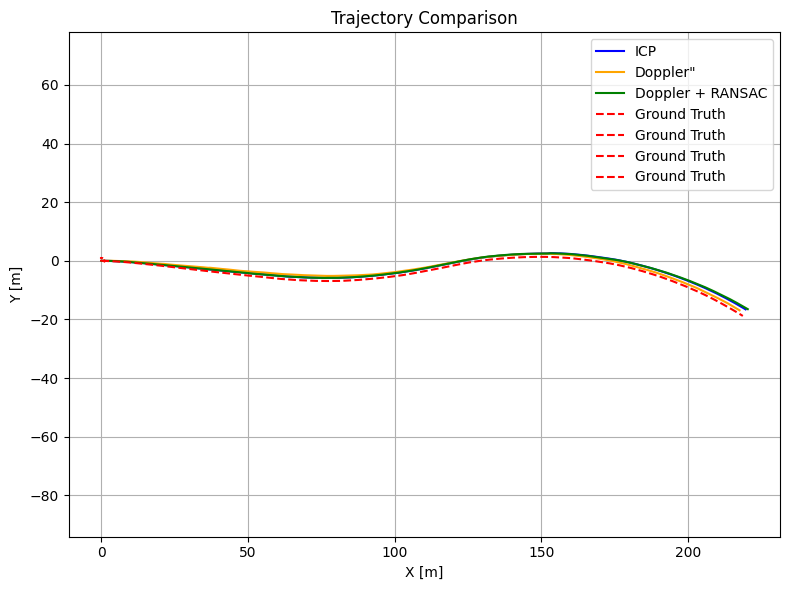

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# initialization
T_init_icp = np.eye(4)
T_init_dop = np.eye(4)
T_init_dop_ransac = np.eye(4)

T_icp_list = [T_init_icp.copy()]
T_dop_list = [T_init_dop.copy()]
T_dop_ransac_list = [T_init_dop_ransac.copy()]

for i in tqdm(range(1, 500)):
    src     = np.load(f"./data_odom/frame_{i:03d}.npy")
    tgt     = np.load(f"./data_odom/frame_{i+1:03d}.npy")
    src_dop = np.load(f"./data_odom/frame_{i:03d}_dop.npy")
    tgt_dop = np.load(f"./data_odom/frame_{i+1:03d}_dop.npy")

    # --- ICP ---
    R_icp, t_icp, _, _ = icp_closest_point(src, tgt)
    T_icp = np.eye(4)
    T_icp[:3, :3] = R_icp
    T_icp[:3, 3]  = t_icp
    T_init_icp = T_init_icp @ np.linalg.inv(T_icp)
    T_icp_list.append(T_init_icp.copy())

    # --- Doppler Correspondence ---
    R_dop, t_dop, _, _ = non_iterative(src, tgt, src_dop, tgt_dop)
    T_dop = np.eye(4)
    T_dop[:3, :3] = R_dop
    T_dop[:3, 3]  = t_dop
    T_init_dop = T_init_dop @ np.linalg.inv(T_dop)
    T_dop_list.append(T_init_dop.copy())

    # --- Doppler + RANSAC ---
    R_dop_r, t_dop_r, _, _ = non_iterative_ransac(src, tgt, src_dop, tgt_dop)
    T_dop_r = np.eye(4)
    T_dop_r[:3, :3] = R_dop_r
    T_dop_r[:3, 3]  = t_dop_r
    T_init_dop_ransac = T_init_dop_ransac @ np.linalg.inv(T_dop_r)
    T_dop_ransac_list.append(T_init_dop_ransac.copy())

# --- Visualization ----------------------------------------------------------
T_icp_arr     = np.array(T_icp_list)
T_dop_arr     = np.array(T_dop_list)
T_dop_r_arr   = np.array(T_dop_ransac_list)
gt_arr        = np.array(gt_list)  # (N, 3)

plt.figure(figsize=(8, 6))
plt.plot(T_icp_arr[:, 0, 3],     T_icp_arr[:, 1, 3],     label='ICP',                color='blue')
plt.plot(T_dop_arr[:, 0, 3],     T_dop_arr[:, 1, 3],     label='Doppler"',            color='orange')
plt.plot(T_dop_r_arr[:, 0, 3],   T_dop_r_arr[:, 1, 3],   label='Doppler + RANSAC',   color='green')
plt.plot(gt_arr[:, 0],           gt_arr[:, 1],           label='Ground Truth',       color='red', linestyle='--')

plt.legend()
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Trajectory Comparison")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
gt_arr      = np.array(gt_list)                  # (N, 4, 4)
est_icp     = np.array(T_icp_list)
est_dop     = np.array(T_dop_list)
est_dop_r   = np.array(T_dop_ransac_list)

gt_trans      = gt_arr[:, :3, 3]
est_icp_trans = est_icp[:, :3, 3]
est_dop_trans = est_dop[:, :3, 3]
est_dop_r_trans = est_dop_r[:, :3, 3]

def compute_rpe_all(gt, est, step=50):
    gt_delta  = gt[step:]  - gt[:-step]
    est_delta = est[step:] - est[:-step]
    errors = np.linalg.norm(est_delta - gt_delta, axis=1)
    return errors

def print_stats(name, errors, unit):
    print(f"{name:<40}:  mean = {errors.mean():.3f}  std = {errors.std():.3f}  median = {np.median(errors):.3f}  [{unit}]")

rpe_icp_all = compute_rpe_all(gt_trans, est_icp_trans)
rpe_dop_all = compute_rpe_all(gt_trans, est_dop_trans)
rpe_dop_r_all = compute_rpe_all(gt_trans, est_dop_r_trans)

print("====== Translation RPE Delta 50======")
print_stats("ICP", rpe_icp_all, "m")
print_stats("Doppler", rpe_dop_all, "m")
print_stats("Doppler + RANSAC", rpe_dop_r_all, "m")

====== Translation RPE Delta 50======
ICP                                     :  mean = 1.914  std = 0.235  median = 1.975  [m]
Doppler                                 :  mean = 1.980  std = 1.112  median = 1.398  [m]
Doppler + RANSAC                        :  mean = 1.910  std = 0.364  median = 1.811  [m]


### Conclusion  

* Without requiring an iterative process, Doppler Correspondence provides reliable correspondences for local registration problems.
* While its performance is not always superior to ICP, a key advantage is that it is less dependent on environmental geometry—whether structured or unstructured.
* To further improve robustness, RANSAC is utilized; nonetheless, alternative strategies such as Maximal Clique Inlier Selection (MCIS) or Graduated Non-Convexity (GNC) can also be considered.